In [ ]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv
from itertools import product
import seaborn as sns
from matplotlib.colors import LogNorm
import rdatasets


## Loading the dataset

In [ ]:
DATASETS = set(["lynx", "ozone"])

In [ ]:
DATASET = "ozone"

assert DATASET in DATASETS, f"Dataset {DATASET} not recognized. Available datasets: {DATASETS}"

In [ ]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
match DATASET:
    case "lynx":
        dataset = rdatasets.data("lynx").drop(columns=["rownames"])
        dataset.set_index('time', inplace=True)
    case "ozone":
        dataset = pd.read_csv("./data/Arosa_Ozone_Thickness_Dataset.csv")
        dataset["year"] = 1925 + dataset["year"]
        dataset["time"] = pd.to_datetime(dataset[["year", "month"]].assign(day=1))
        dataset.set_index("time", inplace=True)
        dataset = dataset.rename(columns={
            "thick": "value"
        }).drop(columns=["year", "month"])
dataset.head()

,value
time,
1926-07-01,312
1926-08-01,300
1926-09-01,281
1926-10-01,267
1926-11-01,295


In [ ]:
dataset.describe()

,value
count,518.000000
mean,336.637066
std,38.221784
min,266.000000
25%,305.000000
50%,335.000000
75%,365.000000
max,430.000000


In [ ]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [ ]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
match DATASET:
    case "lynx":
        time_series = np.log10(time_series)
    case "ozone":
        time_series = np.log10(time_series - 260)

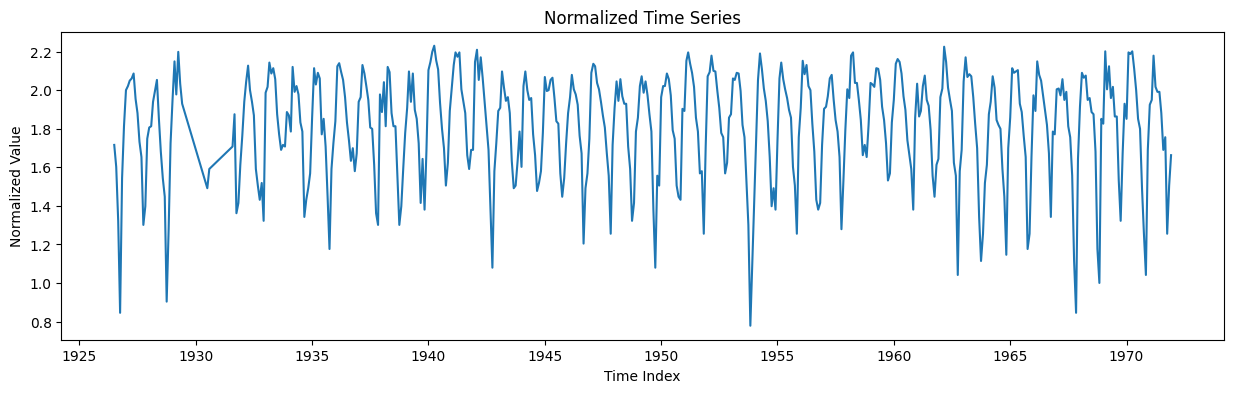

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(dataset.index, time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [ ]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 4


In [ ]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

Estimated dimension: 7


## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [ ]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 4
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [ ]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=4, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [ ]:
tau, dim = tau_cv, dim_cv

In [ ]:
proposed_configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha, beta=beta),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=tuning_val_split,
            ridge=ridge # for pre-training
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for alpha in [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1]
        for beta in [None, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
        for eps in [0, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.5]
        for m in [50, 100, 150, 300]
        # for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        # for approach in ["pretraining", "no-pretraining"]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15, 0.3])
        )
        for ridge, approach in filter(
            lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
            product(
                [0.0, 1e-4, 1e-3, 1e-2, 1e-1], 
                ["pretraining", "no-pretraining"]
            )
        )
    ],
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=OlsOptimizer(rho=rho, alpha=alpha),
            m=max_m,
            n=dim,
            embedding_tau=tau,
            post_tune=post_tune,
            ridge=ridge,
            tuning_val_split=tuning_val_split
        )
        for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 5, 10, 20, 50]
        for max_m in [50, 100, 300]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15, 0.3])
        )        for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
        for ridge, approach in filter(
            lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
            product(
                [0.0, 1e-4, 1e-3, 1e-2, 1e-1], 
                ["pretraining", "no-pretraining"]
            )
        )
    ],
]

control_configs = [
    *[
        ControlGDConfig(
            m=m,
            n=dim,
            embedding_tau=tau,
            lr=lr,
            sigma_global=sigma_global,
            ridge=ridge,
            val_split=0.15,
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
        for lr in [1e-3, 1e-2, 5e-2, 1e-1]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        for sigma_global in [False, True]
    ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        # for m in [10]
        # for ridge in [0]
    ]
]

In [ ]:
TRAIN_RATIOS = {
    "lynx": 0.7, # 0.88 for equivalence with article (no validation-test set separation though...) 
    "ozone": 450/518
}

train_ratio = TRAIN_RATIOS.get(DATASET, 0.7)

In [ ]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=train_ratio, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

KeyboardInterrupt: 

## Evaluating the results

In [ ]:
VALID_RATIOS = {"lynx": 0.2, "ozone": 34/518}

valid_ratio = VALID_RATIOS.get(DATASET, 0.2)

test_ratio = 1.0 - train_ratio - valid_ratio
assert test_ratio > 0, "Test ratio must be positive."

In [ ]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
        "Valid R": [],
        "Valid R^2": [],
        "Valid MSE": [],
        "Valid RMSE": [],
        "Valid NRMSE": [],
        "Valid MAPE": [],
        "Valid SMAPE": [],
        "Valid MAAPE": [],
    }
)


use_validation_set = valid_ratio > 0

for i, res in enumerate(proposed_results):
    
    cfg = proposed_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets,
    )
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']}, eps={cfg.optimizer._epsilon} tuned={res.metadata['post_tuned']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']} tuned={res.metadata['post_tuned']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in enumerate(control_results):
    
    cfg = control_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD' if isinstance(cfg, ControlGDConfig) else 'EM-VP'} (m={res.metadata.get('m_ctrl', cfg.num_components if isinstance(cfg, ControlEMVPConfig) else cfg.m)}, lr={cfg.lr if hasattr(cfg, 'lr') else np.nan}, ridge={cfg.ridge})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [ ]:
MODEL_SELECTION_CRITERION = "Valid MSE"
MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

MODEL_EVALUATION_CRITERION = "Test MSE"
MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE = False

In [ ]:
results_df.groupby("Type")[results_df.columns].apply(
    lambda x: x.sort_values(
        by=MODEL_SELECTION_CRITERION,
        ascending=not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE,
    )
    .drop(
        columns=[
            "Type",
            *[col for col in results_df.columns if col.startswith("Valid")],
        ]
    )
    .head(5)
)

Name    Test R  \
Type                                                                         
Control  1016                    EM-VP (m=20, lr=nan, ridge=0.0)  0.716457   
         993                  EM-VP (m=10, lr=nan, ridge=0.0001)  0.703990   
         1009                 EM-VP (m=16, lr=nan, ridge=0.0001)  0.711829   
         1001                 EM-VP (m=14, lr=nan, ridge=0.0001)  0.717667   
         985                   EM-VP (m=8, lr=nan, ridge=0.0001)  0.704071   
Proposed 644   OlsOptimizer-w.pretraining(|C|=300, rho=0.01 t...  0.628742   
         730   OlsOptimizer-w.pretraining(|C|=299, rho=0.1 tu...  0.643115   
         416   OlsOptimizer-w.pretraining(|C|=300, rho=0.2 tu...  0.589262   
         654   OlsOptimizer-w.pretraining(|C|=300, rho=0.1 tu...  0.672469   
         182   OlsOptimizer-w.pretraining(|C|=300, rho=0.3 tu...  0.280576   

               Test R^2  Test MSE  Test RMSE  Test NRMSE  Test MAPE  \
Type                                                                  
Control  1016  0.440523  0.048099   0.219314    0.758456   0.104457   
         993   0.448144  0.047443   0.217815    0.806026   0.104624   
         1009  0.457054  0.046677   0.216049    0.788649   0.103069   
         1001  0.463221  0.046147   0.214819    0.775652   0.102943   
         985   0.442979  0.047887   0.218832    0.799357   0.104008   
Proposed 644   0.190474  0.069595   0.263809    0.864929   0.124984   
         730   0.310571  0.059271   0.243456    0.878944   0.115085   
         416   0.188260  0.069786   0.264170    0.969051   0.129870   
         654   0.424312  0.049492   0.222468    0.915627   0.105466   
         182  -1.015765  0.173296   0.416289    1.109686   0.175127   

               Test SMAPE  Test MAAPE  
Type                                   
Control  1016    0.052182    0.103092  
         993     0.051526    0.102943  
         1009    0.050796    0.101506  
         1001    0.051075    0.101522  
         985     0.051279    0.102348  
Proposed 644     0.063997    0.121807  
         730     0.057292    0.112869  
         416     0.065134    0.127145  
         654     0.051992    0.103692  
         182     0.093846    0.168876

In [ ]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", MODEL_SELECTION_CRITERION], ascending=[False, not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: OlsOptimizer-w.pretraining(|C|=300, rho=0.01 tuned=True)


In [ ]:
AXIS_LIM = (0, 1)

Correlations between Valid and Test metrics:
Control 0.8612355689236744
Proposed 0.5441376018943151


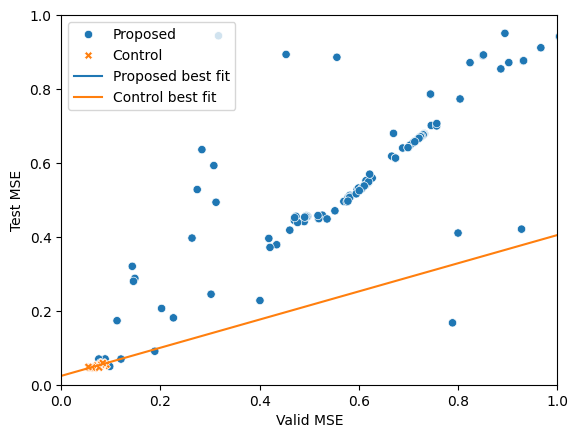

In [ ]:
valid_metric = (
    MODEL_SELECTION_CRITERION
    if MODEL_SELECTION_CRITERION.startswith("Valid")
    else "Valid " + MODEL_SELECTION_CRITERION.split(" ")[1]
)
test_metric = (
    "Test " + MODEL_EVALUATION_CRITERION.split(" ")[1]
    if MODEL_EVALUATION_CRITERION.startswith("Valid")
    else MODEL_EVALUATION_CRITERION
)
sns.scatterplot(
    data=results_df, x=valid_metric, y=test_metric, hue="Type", style="Type"
)
plt.xlim(*AXIS_LIM)
plt.ylim(*AXIS_LIM)
# Calculate correlations for each category
correlations = results_df.groupby("Type")[results_df.columns].apply(
    lambda df: df[valid_metric].corr(df[test_metric])
)
print("Correlations between Valid and Test metrics:")
print("Control", correlations.get("Control", np.nan))
print("Proposed", correlations.get("Proposed", np.nan))

# Add best fit lines for each category
for typ in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == typ]
    x = subset[valid_metric]
    y = subset[test_metric]
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(*AXIS_LIM, 100)
    plt.plot(x_line, m * x_line + b, label=f"{typ} best fit")
plt.legend()
plt.show()

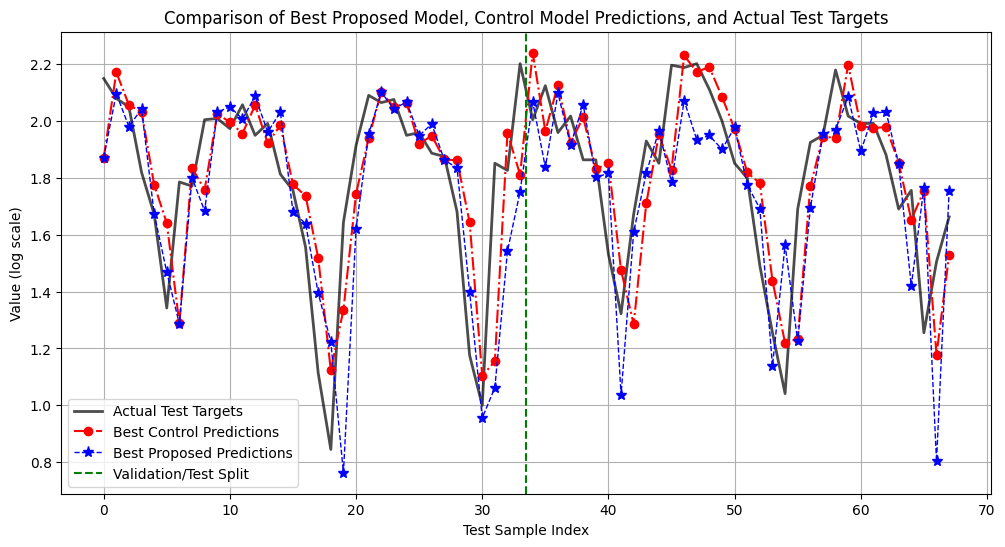

In [ ]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.axvline(x=validation_cutoff + 0.5, color='green', linestyle='--', label='Validation/Test Split')
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Effects of individual hyperparameters

In [ ]:
# HYPERPARAM = "optimizer._alpha"
HYPERPARAM = "ridge"
# HYPERPARAM = "num_components"
METRIC_LOG_SCALE = True
PARAM_LOG_SCALE = True

PROPOSED_HYPERPARAM = True

In [ ]:
hyperparam_values = sorted(
    map(
        lambda cfg: cfg.__dict__.get(HYPERPARAM, None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
    if not HYPERPARAM.startswith("optimizer.")
    else
    map(
        lambda cfg: cfg.optimizer.__dict__.get(HYPERPARAM.split(".")[1], None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
)
hyperparam_results_df = results_df[results_df["Type"] == ("Proposed" if PROPOSED_HYPERPARAM else "Control")].copy()
hyperparam_results_df[HYPERPARAM] = hyperparam_values

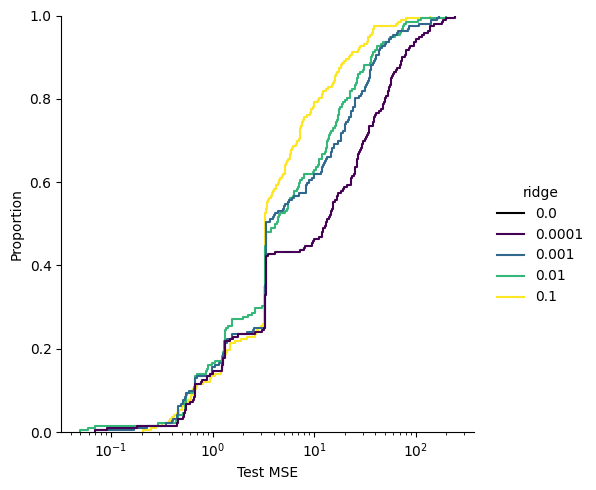

In [ ]:
sns.displot(
    data=hyperparam_results_df,
    x=test_metric,
    hue=HYPERPARAM,
    hue_norm=LogNorm() if PARAM_LOG_SCALE else None,
    kind="ecdf",
    palette="viridis",
    log_scale=(METRIC_LOG_SCALE, False),
)
# plt.xlim(right= np.log10(hyperparam_results_df[test_metric].max() / 10))
plt.show()

### Control models

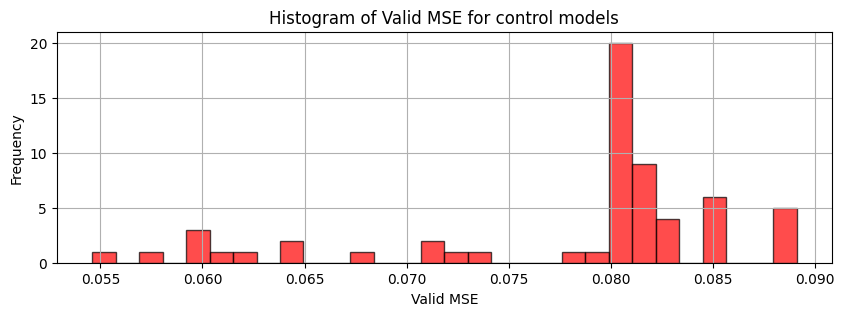

In [ ]:
control_models = results_df[results_df["Type"] == "Control"]
plt.figure(figsize=(10, 3))
plt.hist(control_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for control models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Breakdown of methods

#### Best OLS model without tuning

In [ ]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
not_tuned_ols_models = results_df[
    results_df["Name"].str.contains("OLS", case=False, na=False)
    & results_df["Name"].str.contains("tuned=False", case=False, na=False)
]

if not_tuned_ols_models.empty:
    best_not_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_ols_model = not_tuned_ols_models.loc[
        (
            not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_not_tuned_ols_model is None:
    print("No untuned OLS models found.")
else:
    print(best_not_tuned_ols_model["Name"])
    print("=" * 20)
    print(best_not_tuned_ols_model.drop(labels=["Type", "Name"]))

OlsOptimizer-w.pretraining(|C|=50, rho=0.01 tuned=False)
Test R          0.260703
Test R^2      -42.616536
Test MSE        3.749739
Test RMSE       1.936424
Test NRMSE      3.764698
Test MAPE       1.038265
Test SMAPE      0.838453
Test MAAPE      0.781376
Valid R         0.349635
Valid R^2     -25.058734
Valid MSE       2.790955
Valid RMSE      1.670615
Valid NRMSE     1.987065
Valid MAPE      0.930054
Valid SMAPE     0.712635
Valid MAAPE     0.710149
Name: 600, dtype: object


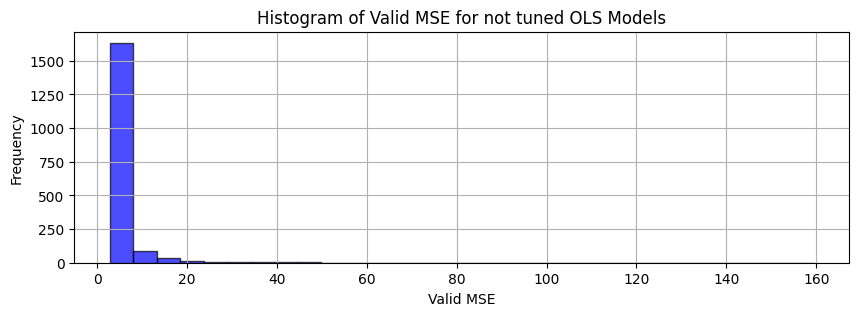

In [ ]:
if not not_tuned_ols_models.empty:
    plt.figure(figsize=(10, 3))
    plt.hist(not_tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned OLS Models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("No untuned OLS models found, skipping histogram.")

#### Best OLS-based model with tuning

In [ ]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
tuned_ols_models = results_df[results_df["Name"].str.contains("OLS", case=False, na=False) & 
                        results_df["Name"].str.contains("tuned=True", case=False, na=False)]

if tuned_ols_models.empty:
    best_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_ols_model = tuned_ols_models.loc[
        (
            tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_tuned_ols_model is None:
    print("No tuned OLS models found.")
else:
    print(best_tuned_ols_model["Name"])
    print("="*20)
    print(best_tuned_ols_model.drop(labels=["Type", "Name"]))

OlsOptimizer-w.pretraining(|C|=100, rho=0.01 tuned=True)
Test R         0.557476
Test R^2      -0.371056
Test MSE       0.117871
Test RMSE      0.343323
Test NRMSE     0.929899
Test MAPE      0.136337
Test SMAPE     0.076238
Test MAAPE      0.13092
Valid R         0.78149
Valid R^2      0.266486
Valid MSE      0.078561
Valid RMSE     0.280288
Valid NRMSE    0.639633
Valid MAPE     0.128415
Valid SMAPE    0.074821
Valid MAAPE    0.122507
Name: 1441, dtype: object


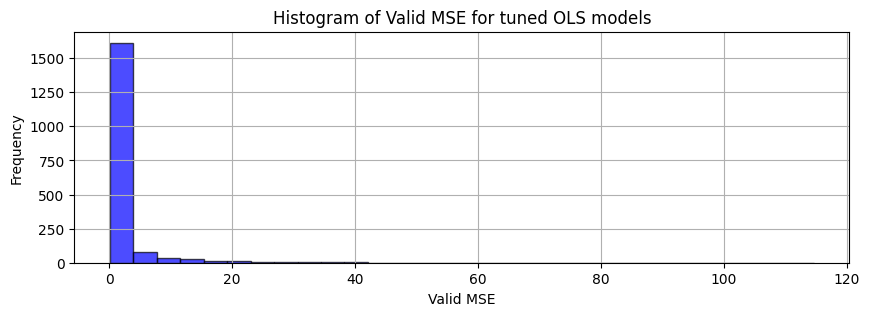

In [ ]:
if tuned_ols_models.empty:
    print("No tuned OLS models found, skipping histogram.")
else:
    plt.figure(figsize=(10, 3))
    plt.hist(tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned OLS models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### Best SVD-based model without tuning

In [ ]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
not_tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
not_tuned_svd_models = not_tuned_svd_models[not_tuned_svd_models["Name"].str.contains("tuned=False", case=False, na=False)]

if not_tuned_svd_models.empty:
    best_not_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_svd_model = not_tuned_svd_models.loc[
        (
            not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_svd_model["Name"])
print("="*20)
print(best_not_tuned_svd_model.drop(labels=["Type", "Name"]))

TypeError: 'NoneType' object is not subscriptable

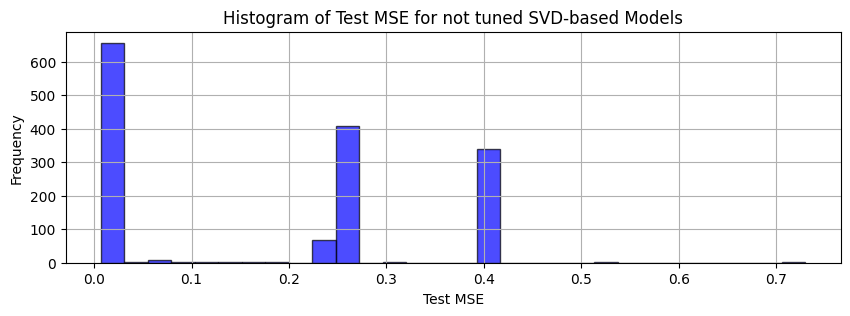

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model with tuning

In [ ]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
tuned_svd_models = tuned_svd_models[
    tuned_svd_models["Name"].str.contains("tuned=True", case=False, na=False)
]

if tuned_svd_models.empty:
    best_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_svd_model = tuned_svd_models.loc[
        (
            tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_svd_model["Name"])
print("=" * 20)
print(best_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0 tuned=True)
Test R        0.978072
Test R^2      0.950985
Test MSE      0.006721
Test RMSE      0.08198
Test NRMSE    0.216678
Test MAPE     0.023502
Test SMAPE    0.011733
Test MAAPE    0.023491
Name: 886, dtype: object


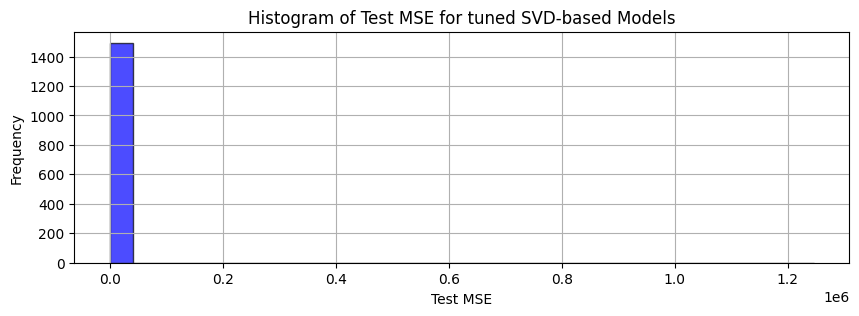

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()